<a href="https://colab.research.google.com/github/SandipPalit/Case-Studies/blob/main/.%5CCase%20Study%20Regression%20model%20on%20Timeline%20Data%5CCase_Study_Regression_model_on_Timeline_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Study: Regression model on Timeline Data**  - By Sandip Palit



---



## Setup

In [ ]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
from datetime import datetime
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')



---



## Data Collection

The dataset employed in this analysis originates from **Timeline data**, a service that chronologically records a user's location history based on their device's location services. This data, encompassing timestamps, geographical coordinates, and inferred modes of transport, provides a rich source of information regarding an individual's movement patterns. Timeline data, stored in JSON format, was retrieved from my phone, enabling us to analyse my travel pattern.



---



## Data Extraction

The objective of this **Data Extraction** is to process location data from a JSON file, extracting key information such as timestamps, geographical details, and modes of transport. It leverages the geopy library for reverse geocoding and stores the structured output in a CSV file for subsequent analysis. The script aims to transform raw location data into a more usable and insightful format.

**Input: Timeline.json**

**Output: Parsed.csv**


In [ ]:
# Initialize Nominatim geolocator
geolocator = Nominatim(user_agent="sp", timeout=100)

# Read JSON data from file
with open('Timeline.json', 'r') as file:
    data = json.load(file)

# Create an empty DataFrame with specified columns
df = pd.DataFrame(columns=['StartTime', 'Duration','Start Location','Start City/Town','End Location','End City/Town','Distance','Mode of Transport','City/Town'])
i=-1

# Iterate through semantic segments in the JSON data
for item in data["semanticSegments"]:
  if "activity" in item:
    try:  # Try to extract location information
        # Get start location address using reverse geocoding
        address = geolocator.reverse(item["activity"]["start"]["latLng"]).raw['address']

        # Check if the address is within India and has suburb information
        if "suburb" in address and "India" in address.get("country", "") :
            # Extract start location details
            suburb_start = address.get("suburb")
            town_start = address.get("town")
            city_start = address.get("city")

            # Get end location address using reverse geocoding
            address_end = geolocator.reverse(item["activity"]["end"]["latLng"]).raw['address']

            # Extract end location details
            suburb_end = address_end.get("suburb")
            town_end = address_end.get("town")
            city_end = address_end.get("city")

            i=i+1 # Increment index for DataFrame

            # Add data to DataFrame based on available location information
            if town_start and town_end:
                # If both start and end towns are available, use them
                df.loc[i] = list([datetime.strptime(item["startTime"].split(".")[0],"%Y-%m-%dT%H:%M:%S"),(datetime.strptime(item["endTime"].split(".")[0],"%Y-%m-%dT%H:%M:%S")-datetime.strptime(item["startTime"].split(".")[0],"%Y-%m-%dT%H:%M:%S")).total_seconds()//60,suburb_start,town_start,suburb_end, town_end, item["activity"]["distanceMeters"],item["activity"]["topCandidate"]["type"],"Town"])
            elif city_start and city_end:
                # If both start and end cities are available, use them
                df.loc[i] = list([datetime.strptime(item["startTime"].split(".")[0],"%Y-%m-%dT%H:%M:%S"),(datetime.strptime(item["endTime"].split(".")[0],"%Y-%m-%dT%H:%M:%S")-datetime.strptime(item["startTime"].split(".")[0],"%Y-%m-%dT%H:%M:%S")).total_seconds()//60,suburb_start,city_start, suburb_end, city_end, item["activity"]["distanceMeters"],item["activity"]["topCandidate"]["type"],"City"])

    except KeyError as e:  # Handle KeyError if a key is missing
        print(f"Skipping item due to missing key: {e}")

# Save the DataFrame to a CSV file
df.to_csv("Parsed.csv",index=False)



---



## Data Preparation and Exploratory data analysis


The **Data Preprocessing** stage aims to refine the extracted Timeline data for analysis. This involves outlier removal and filtering based on mode of transport frequency. Outliers in 'Distance' and 'Duration' are identified and removed using the Interquartile Range (IQR) method. Subsequently, only modes of transport occurring 100 times or more are retained. These steps ensure data quality and focus on the most frequent travel patterns for further analysis.

**Input: Parsed.csv**

In [ ]:
# Load the preprocessed data from the CSV file
df = pd.read_csv('Parsed.csv')
display(df)

,StartTime,Duration,Start Location,Start City/Town,End Location,End City/Town,Distance,Mode of Transport,City/Town
0,2016-09-19 09:38:10,19.0,Hindmotor,Konnagar,Hindmotor,Uttarpara Kotrung,280.000000,CYCLING,Town
1,2016-09-19 19:25:11,10.0,Ripon Street,Kolkata,New Market,Kolkata,172.000000,WALKING,City
2,2016-09-19 21:02:46,44.0,Hindmotor,Uttarpara Kotrung,Hindmotor,Konnagar,1514.000000,WALKING,Town
3,2016-09-21 23:47:54,4.0,Hindmotor,Konnagar,Hindmotor,Konnagar,15702.000000,WALKING,Town
4,2016-09-22 13:28:44,21.0,Ripon Street,Kolkata,Ripon Street,Kolkata,16177.000000,WALKING,City
...,...,...,...,...,...,...,...,...,...
1617,2024-10-15 08:53:01,14.0,Sector V,Bidhannagar,Sector V,Bidhannagar,865.371460,WALKING,Town
1618,2024-10-15 16:16:14,76.0,Sector V,Bidhannagar,Hindmotor,Konnagar,29192.810547,IN_BUS,Town
1619,2024-10-15 17:32:33,6.0,Hindmotor,Konnagar,Hindmotor,Konnagar,437.590271,WALKING,Town
1620,2024-10-17 07:31:02,3.0,Hindmotor,Konnagar,Hindmotor,Konnagar,298.390869,WALKING,Town


The functions is_indian_holiday_or_weekend and get_time_of_day are designed to augment the dataset with temporal classifications. The former categorizes a given date as either a holiday, weekend, or neither, by checking against the Indian holiday calendar and weekday values. The latter function assigns a time-of-day label ('Morning', 'Afternoon', 'Evening', or 'Night') to each record based on the hour extracted from the 'StartTime' column. These classifications provide contextual information for subsequent analysis of travel patterns.

In [ ]:
def is_indian_holiday_or_weekend(date):
  in_holidays = date in holidays.IN()
  is_weekend = date.weekday() in [5, 6]  # 5: Saturday, 6: Sunday

  if in_holidays:
    return "Holiday"
  elif is_weekend:
    return "Weekend"
  else:
    return "Neither"

def get_time_of_day(row):
  hour = pd.to_datetime(row['StartTime']).hour
  if 5 <= hour < 12:
    return 'Morning'
  elif 12 <= hour < 17:
    return 'Afternoon'
  elif 17 <= hour < 21:
    return 'Evening'
  else:
    return 'Night'

# Extract the date part from the 'StartTime' column
df.loc[:, 'Date'] = pd.to_datetime(df['StartTime']).dt.date

# Apply the function to create a new 'TimeOfDay' column
df.loc[:, 'TimeOfDay'] = df.apply(get_time_of_day, axis=1)

# Compute whether it's a Holiday or a Weekend
df.loc[:, 'Holiday_Status'] = df['Date'].apply(is_indian_holiday_or_weekend)

# Convert 'Distance' to kilometers and round to 2 decimal places
df.loc[:, 'Distance(m)'] = df['Distance'].astype(int)
df = df[df['Distance(m)'] != 0]

# Extract the integer part of 'Duration'
df.loc[:, 'Duration(min)'] = df['Duration'].astype(int)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Removing the unnecessary columns
df = df.drop(['StartTime', 'Duration', 'Distance'], axis=1)

Real-time data often contains numerous outliers, which were removed to enhance the accuracy and reliability of the analysis. The below cell identified and removed outliers in 'Speed' i.e, 'Distance' / 'Duration' using the Interquartile Range (IQR) method. This removed the outliers from both 'Distance' and 'Duration'. Based on my Prior knowledge on the traffic conditions in West Bengal, India, it's almost practically impossible to achieve 200kmph (i.e, 3333.33 metre/minute), so I removed records with speed greater than 3333.33 metre/minute. Outlier thresholds are calculated, and data points outside these thresholds are filtered out, resulting in a dataset with reduced noise for improved analysis.


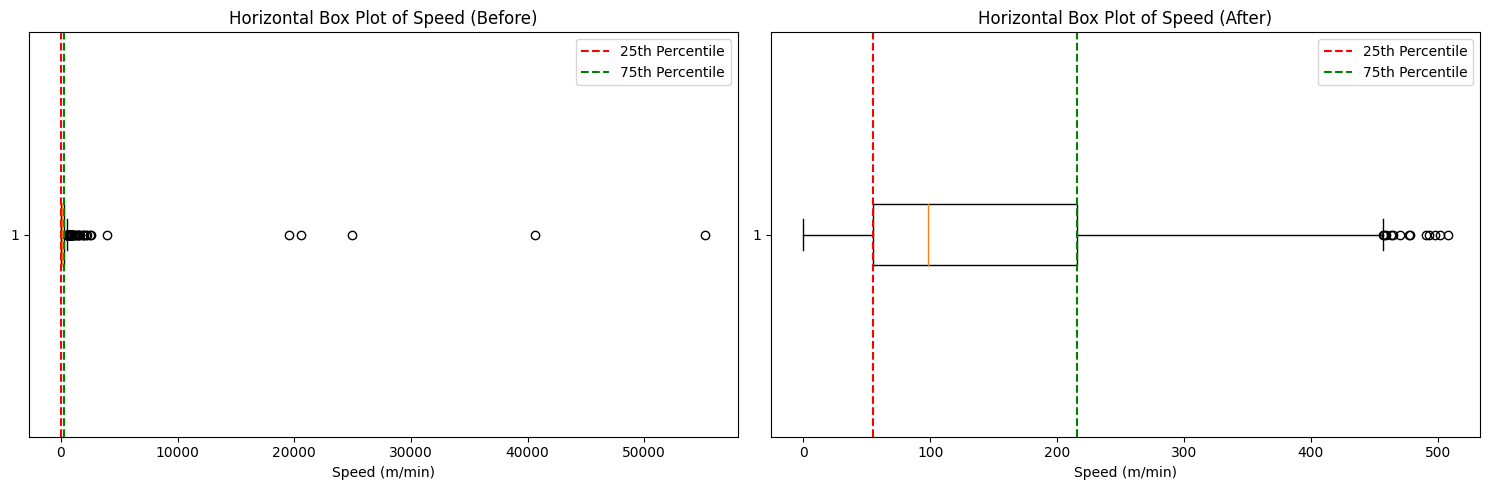

In [ ]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Calculate speed
df['Speed'] = df['Distance(m)'] / df['Duration(min)']

# Plot the first boxplot on the left subplot (ax1)
# Replace this with your actual code to create the first plot
ax1.boxplot(df['Speed'], vert=False)
ax1.axvline(df['Speed'].quantile(0.25), color='red', linestyle='--', label='25th Percentile')
ax1.axvline(df['Speed'].quantile(0.75), color='green', linestyle='--', label='75th Percentile')
ax1.set_xlabel('Speed (m/min)')
ax1.set_title('Horizontal Box Plot of Speed (Before)')
ax1.legend()

# remove speed >= 3333.33 metre/minute based on prior knowledge
df = df[df['Speed'] < 3333.33]

# Calculate the IQR for Speed
Q1 = df['Speed'].quantile(0.25)
Q3 = df['Speed'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on the bounds
df = df[(df['Speed'] >= lower_bound) & (df['Speed'] <= upper_bound)]

# Plot the second boxplot on the right subplot (ax2)
# Replace this with your actual code to create the second plot
ax2.boxplot(df['Speed'], vert=False)
ax2.axvline(df['Speed'].quantile(0.25), color='red', linestyle='--', label='25th Percentile')
ax2.axvline(df['Speed'].quantile(0.75), color='green', linestyle='--', label='75th Percentile')
ax2.set_xlabel('Speed (m/min)')
ax2.set_title('Horizontal Box Plot of Speed (After)')
ax2.legend()

plt.tight_layout()
plt.show()

df = df.drop(['Speed'], axis=1)


**Observations:**
* The interquartile range for speed indicates that the majority of recorded travel speeds fall between 55 and 207 meters per minute.

* Specifically, the 25th percentile for speed is 55 meters per minute, while the 75th percentile is 207 meters per minute.
* This suggests that the central 50% of the data, representing typical travel speeds, is concentrated within this range.

Analysis revealed a significant class imbalance within the dataset. To address this in the below mentioned cell, modes of transport comprising less than 5% of the total records were excluded from subsequent analysis, ensuring a more balanced representation of prevalent transportation methods



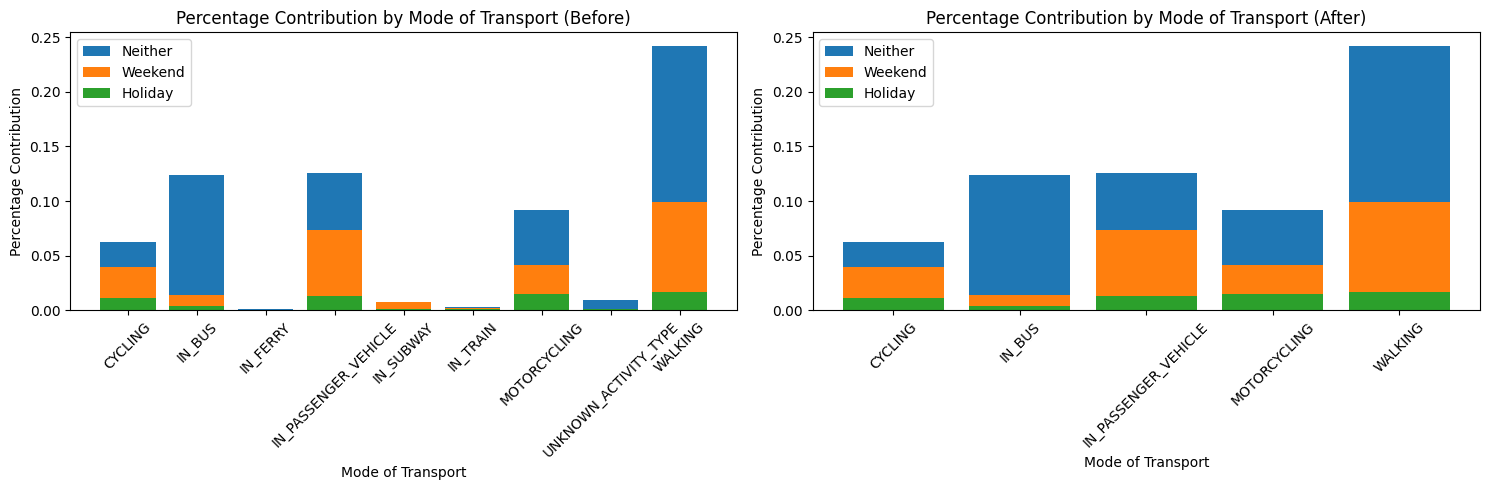

In [ ]:
dataset_size = len(df)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Group the DataFrame by 'Mode of Transport' and count the occurrences of each mode
mode_counts = df.groupby('Mode of Transport')['Mode of Transport'].count()
# Create the bar plot before transformation
for status in df['Holiday_Status'].unique():
    subset = df[df['Holiday_Status'] == status]
    mode_counts_subset = subset.groupby('Mode of Transport')['Mode of Transport'].count()
    ax1.bar(mode_counts_subset.index, mode_counts_subset.values / dataset_size, label=status)
ax1.set_xlabel('Mode of Transport')
ax1.set_ylabel('Percentage Contribution')
ax1.set_title('Percentage Contribution by Mode of Transport (Before)')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# Calculate the threshold for removing modes with less than 5% occurrence
threshold = dataset_size * 0.05

# Filter out modes with counts less than the threshold
df = df[df['Mode of Transport'].isin(mode_counts[mode_counts >= threshold].index)]

# Group the DataFrame by 'Mode of Transport' and count the occurrences of each mode
mode_counts = df.groupby('Mode of Transport')['Mode of Transport'].count()
# Create the bar plot after transformation
for status in df['Holiday_Status'].unique():
    subset = df[df['Holiday_Status'] == status]
    mode_counts_subset = subset.groupby('Mode of Transport')['Mode of Transport'].count()
    ax2.bar(mode_counts_subset.index, mode_counts_subset.values / dataset_size, label=status)
ax2.set_xlabel('Mode of Transport')
ax2.set_ylabel('Percentage Contribution')
ax2.set_title('Percentage Contribution by Mode of Transport (After)')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

**Observations:**
* The modes of transport, namely, IN_FERRY, IN_SUBWAY, IN_TRAIN, and UNKNOWN_ACTIVITY_TYPE, were found to constitute less than 5% of the overall dataset. These infrequent modes were excluded from further analysis to ensure a balanced representation of prevalent transportation methods.

* During weekdays (non-holidays), my preferred modes of transportation include walking and bus travel.
* For weekend and holiday travel, I prefer cycling and traveling in a passenger vehicle.



To visualize the relationship between distance and duration for each mode of transport in the below cell, the distinct modes were first identified. For each mode of transport, a scatter plot was generated, depicting the correlation between distance and duration. Each subplot was labeled with the corresponding mode and equipped with grid lines for enhanced readability.



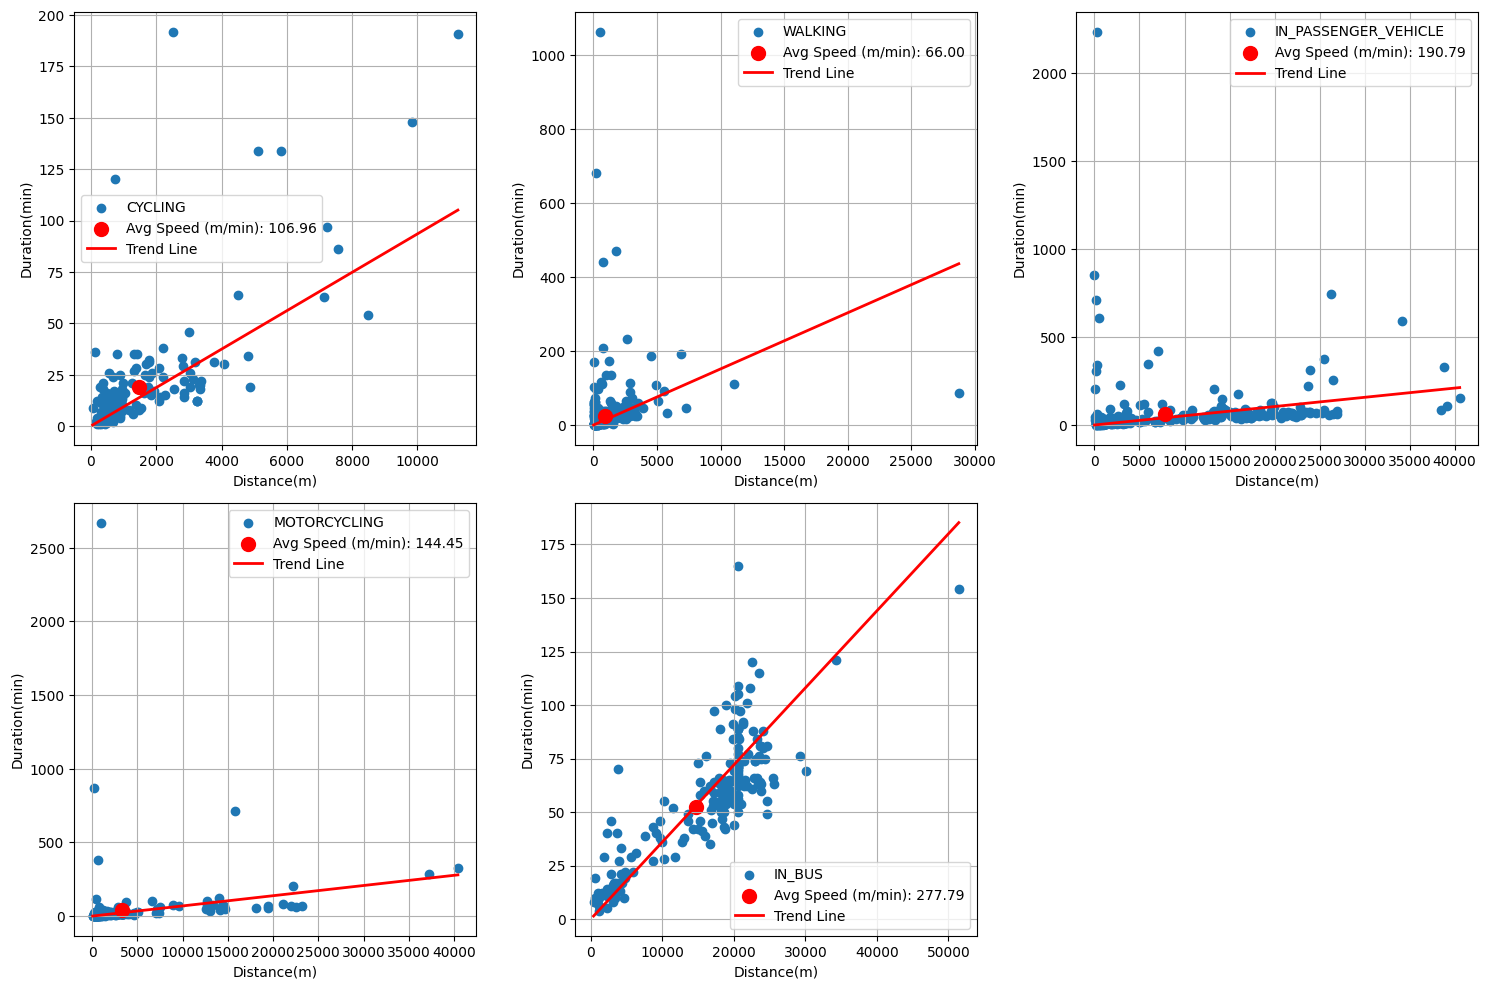

In [ ]:
# Get unique modes of transport
modes_of_transport = df['Mode of Transport'].unique()

# Calculate the number of rows needed for 4 columns
num_rows = (len(modes_of_transport) + 3) // 3

# Create subplots with 3 columns and calculated rows
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through modes of transport and plot on subplots
for i, mode in enumerate(modes_of_transport):
    subset = df[df['Mode of Transport'] == mode]

    # Calculate average speed for the subset
    avg_speed = (subset['Distance(m)'] / subset['Duration(min)']).mean()

    # Scatter plot for the subset
    axes[i].scatter(subset['Distance(m)'], subset['Duration(min)'], label=mode)

    # Plot average speed as a red point
    axes[i].scatter(subset['Distance(m)'].mean(), subset['Duration(min)'].mean(), color='red', marker='o', s=100, label=f'Avg Speed (m/min): {avg_speed:.2f}')

    # Plot trend line from min to max in red
    x_min = subset['Distance(m)'].min()
    x_max = subset['Distance(m)'].max()

    # Calculate y values for trend line using average speed
    y_min = x_min / avg_speed
    y_max = x_max / avg_speed

    axes[i].plot([x_min, x_max], [y_min, y_max],
                 color='red', linestyle='-', linewidth=2, label='Trend Line')

    axes[i].set_xlabel('Distance(m)')
    axes[i].set_ylabel('Duration(min)')
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Observations:**
* Walking exhibits the lowest average speed among the analyzed modes of transport, which is pretty obvious.

* Buses demonstrate the highest average speed, indicating their efficiency for traversing distances within this dataset.
* Passenger vehicles achieve an intermediate average speed, ranking between buses and motorcycling in terms of travel time.

To analyze travel patterns in October 2024, a subset of the data was extracted, focusing solely on records from that month. Subsequently, a figure comprising two subplots was generated for comparative visualization. The first subplot displays a bar chart illustrating the daily travel duration for each mode of transport throughout October. This chart is labeled with 'Date' on the x-axis and 'Duration (min)' on the y-axis, providing a clear representation of temporal travel trends.



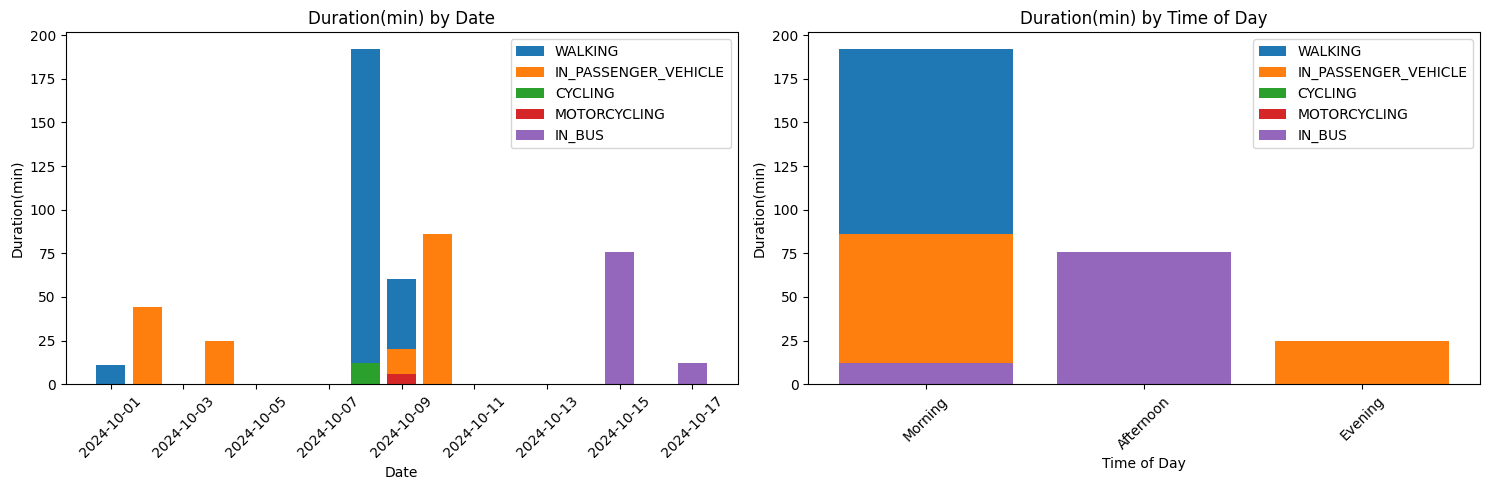

In [ ]:
# Filter for October 2024
df_october = df[(df['Date'].dt.year == 2024) & (df['Date'].dt.month == 10)]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Create the Date vs Duration bar plot, grouped by Mode of Transport
for mode in df_october['Mode of Transport'].unique():
    subset = df_october[df_october['Mode of Transport'] == mode]
    ax1.bar(subset['Date'], subset['Duration(min)'], label=mode)
ax1.set_xlabel('Date')
ax1.set_ylabel('Duration(min)')
ax1.set_title('Duration(min) by Date')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# Create the TimeOfDay vs Duration bar plot, grouped by Mode of Transport
for mode in df_october['Mode of Transport'].unique():
    subset = df_october[df_october['Mode of Transport'] == mode]
    ax2.bar(subset['TimeOfDay'], subset['Duration(min)'], label=mode)
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Duration(min)')
ax2.set_title('Duration(min) by Time of Day')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

**Observations:**
* October 8th recorded the highest travel duration, primarily attributed to walking. This aligns with the Durga Puja festival in Kolkata, where frequent visits to pandals likely contributed to increased walking activity.
* My preferred travel time is during the morning hours and no night-time travel was undertaken during October.

Finally, the 'Date' column was decomposed into separate 'Day', 'Month', and 'Year' columns, each represented as integers. Redundant columns were removed to streamline the dataset.

In [ ]:
# Split the 'Date' column into 'Day', 'Month', and 'Year' columns with integer data type
df['Day'] = pd.to_datetime(df['Date']).dt.day.astype(int)
df['Month'] = pd.to_datetime(df['Date']).dt.month.astype(int)
df['Year'] = pd.to_datetime(df['Date']).dt.year.astype(int)

# Removing the unnecessary columns
df = df.drop(['Date'], axis=1)

In [ ]:
df_copy=df.copy()



---



## Parameter Estimation

**Poisson Regression** is a type of generalized linear model used primarily for modeling count data. It assumes that the response variable (the dependent variable) follows a Poisson distribution, which is appropriate for counts of events occurring within a fixed interval of time or space.

While Poisson regression is typically used for count data, it can also be applicable in certain contexts involving ordinal data, particularly when the ordinal data represents counts or rates of occurrence. If the duration data can be transformed or categorized into counts or events (e.g., the number of minutes spent on different activities), Poisson regression can still apply. In such cases, duration is treated as a count of time intervals, like in our scenario.

In [ ]:
df=df_copy.copy()

In order to prepare the data for model training, label encoding was performed on categorical features such as 'Start Location', 'Start City/Town', 'End Location', 'End City/Town', 'Mode of Transport', 'City/Town', 'TimeOfDay', and 'Holiday_Status'. This process creates new binary columns for each unique value in these features. Additionally, numerical features like 'Distance(m)', 'Day', 'Month', and 'Year' were standardized to ensure consistent scaling and prevent bias towards features with larger values.

In [ ]:
# Define the columns to be label encoded
columns_to_encode = ['Start Location', 'Start City/Town', 'End Location', 'End City/Town', 'Mode of Transport', 'City/Town', 'TimeOfDay', 'Holiday_Status']

# Create a LabelEncoder object
le = LabelEncoder()

# Iterate through the columns and perform label encoding
for column in columns_to_encode:
  df[column] = le.fit_transform(df[column].astype(str))

for column in ['Distance(m)', 'Day', 'Month', 'Year','Start Location', 'Start City/Town', 'End Location', 'End City/Town', 'Mode of Transport', 'City/Town', 'TimeOfDay', 'Holiday_Status']:
  # Perform standardisation
  df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())



In [ ]:
display(df)

,Start Location,Start City/Town,End Location,End City/Town,Mode of Transport,City/Town,TimeOfDay,Holiday_Status,Distance(m),Duration(min),Day,Month,Year
0,0.477612,0.611111,0.462687,1.00,0.00,1.0,0.666667,0.5,0.005404,19,0.600000,0.727273,0.0
1,0.805970,0.555556,0.716418,0.55,1.00,0.0,0.333333,0.5,0.003304,10,0.600000,0.727273,0.0
2,0.477612,1.000000,0.462687,0.60,1.00,1.0,1.000000,0.5,0.029389,44,0.600000,0.727273,0.0
5,0.805970,0.555556,0.492537,0.40,1.00,0.0,0.333333,0.5,0.098274,64,0.700000,0.727273,0.0
6,0.507463,0.388889,0.358209,0.55,0.50,0.0,0.333333,0.5,0.066766,12,0.700000,0.727273,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,0.880597,0.166667,0.850746,0.20,1.00,1.0,0.666667,0.5,0.016774,14,0.466667,0.818182,1.0
1618,0.880597,0.166667,0.462687,0.60,0.25,1.0,0.000000,0.5,0.567369,76,0.466667,0.818182,1.0
1619,0.477612,0.611111,0.462687,0.60,1.00,1.0,0.333333,0.5,0.008455,6,0.466667,0.818182,1.0
1620,0.477612,0.611111,0.462687,0.60,1.00,1.0,0.666667,0.5,0.005753,3,0.533333,0.818182,1.0


The log-likelihood for **Poisson regression** is given by:

$\begin{align}
\ell(\boldsymbol{\beta}) = \sum_{i=1}^{n} \left( y_i \mathbf{x}_i^T \boldsymbol{\beta} - \exp(\mathbf{x}_i^T \boldsymbol{\beta}) \right)
\end{align}$

To find the **Maximum Likelihood Estimate (MLE)**, we take the gradient of the log-likelihood and set it to zero:

$\begin{align}
\frac{\partial \ell(\boldsymbol{\beta})}{\partial \boldsymbol{\beta}} = \sum_{i=1}^{n} \mathbf{x}_i \left( y_i - \exp(\mathbf{x}_i^T \boldsymbol{\beta}) \right) = 0
\end{align}$

This equation is solved iteratively using methods to find the MLE estimate $(\hat{\boldsymbol{\beta}}_{\text{MLE}})$.

For **Maximum A Posteriori (MAP) Estimation**, we add a prior to the likelihood. Assuming a Gaussian prior $( \boldsymbol{\beta} \sim \mathcal{N}(0, \sigma^2 I) )$, the log-posterior is:

$\begin{align}
\log P(\boldsymbol{\beta} | \mathbf{y}) = \sum_{i=1}^{n} \left( y_i \mathbf{x}_i^T \boldsymbol{\beta} - \exp(\mathbf{x}_i^T \boldsymbol{\beta}) \right) - \frac{1}{2 \sigma^2} \boldsymbol{\beta}^T \boldsymbol{\beta}
\end{align}$

Taking the gradient and setting it to zero gives:

$\begin{align}
\frac{\partial}{\partial \boldsymbol{\beta}} \log P(\boldsymbol{\beta} | \mathbf{y}) = \sum_{i=1}^{n} \mathbf{x}_i \left( y_i - \exp(\mathbf{x}_i^T \boldsymbol{\beta}) \right) - \frac{1}{\sigma^2} \boldsymbol{\beta} = 0
\end{align}$

This equation is solved iteratively to find the MAP estimate $( \hat{\boldsymbol{\beta}}_{\text{MAP}} )$.


We will use the helper functions mentioned below:

* **poisson_log_likelihood:**
This function calculates the log-likelihood for Poisson regression. It computes the Poisson mean (lambda_), clips it to avoid overflow or underflow, and returns the sum of the log-likelihood across all data points.

* **poisson_log_likelihood_map:**
This is the log-likelihood function for Poisson regression with L2 regularization (used in MAP). It adds an L2 penalty to the standard log-likelihood to regularize the model's weights and prevent overfitting.

* **poisson_gradient:**
This function computes the gradient of the log-likelihood for Poisson regression. The gradient is used to update the model's weights during training via gradient descent.

* **poisson_gradient_map:**
This computes the gradient for Poisson regression with L2 regularization (for MAP). It adds a regularization term to the gradient to encourage smaller weights and prevent overfitting.

* **poisson_regression_mle:**
This function implements Poisson regression using Maximum Likelihood Estimation (MLE). It uses gradient descent to iteratively update the model's weights until convergence or the maximum number of iterations is reached.

* **poisson_regression_map:**
This function implements Poisson regression with Maximum A Posteriori (MAP) estimation. It adds L2 regularization to the gradient descent process to prevent large weight values and improve generalization.

* **predict_poisson:**
This function makes predictions using the trained Poisson regression model. It calculates the predicted Poisson means and clips the values to avoid numerical issues like overflow.

* **get_important_features:**
This function identifies and returns the most important features based on the values of the model's learned weights. It ranks features by the magnitude of their corresponding weights and selects the top N important features.

In [ ]:
# Poisson log-likelihood function
def poisson_log_likelihood(X, y, weights):
    lambda_ = np.exp(np.dot(X, weights))
    lambda_ = np.clip(lambda_, 1e-10, 1e10)
    return np.sum(y * np.dot(X, weights) - lambda_)

# Poisson log-likelihood function with L2 regularization (for MAP)
def poisson_log_likelihood_map(X, y, weights, l2_penalty):
    lambda_ = np.exp(np.dot(X, weights))
    lambda_ = np.clip(lambda_, 1e-10, 1e10)
    log_likelihood = np.sum(y * np.dot(X, weights) - lambda_)
    l2_regularization = -l2_penalty * np.sum(weights ** 2)
    return log_likelihood + l2_regularization

# Gradient of the log-likelihood for Poisson regression
def poisson_gradient(X, y, weights):
    lambda_ = np.exp(np.dot(X, weights))
    lambda_ = np.clip(lambda_, 1e-10, 1e10)
    return np.dot(X.T, y - lambda_)

# Gradient of the log-likelihood for MAP (Poisson regression with L2 regularization)
def poisson_gradient_map(X, y, weights, l2_penalty):
    lambda_ = np.exp(np.dot(X, weights))
    lambda_ = np.clip(lambda_, 1e-10, 1e10)
    gradient = np.dot(X.T, y - lambda_)
    l2_gradient = -2 * l2_penalty * weights
    return gradient + l2_gradient

# Poisson Regression (MLE) with Gradient Descent
def poisson_regression_mle(X, y, learning_rate, max_iter, tol):
    weights = np.zeros(X.shape[1])
    for i in range(max_iter):
        grad = poisson_gradient(X, y, weights)
        weights += learning_rate * grad
        # Convergence check
        if np.linalg.norm(grad) < tol:
            break
    return weights

# Poisson Regression (MAP) with Gradient Descent
def poisson_regression_map(X, y, learning_rate, l2_penalty, max_iter, tol):
    weights = np.zeros(X.shape[1])  # Initialize weights
    for i in range(max_iter):
        grad = poisson_gradient_map(X, y, weights, l2_penalty)
        weights += learning_rate * grad  # Update weights with L2 regularization
        # Convergence check
        if np.linalg.norm(grad) < tol:
            break
    return weights

# Prediction function for Poisson Regression
def predict_poisson(X, weights):
    predictions = np.exp(np.dot(X, weights))
    return np.clip(predictions, 1e-10, 1e10)

def get_important_features(weights, feature_names, top_n):
    # Sort the features by the magnitude of their weights (absolute value)
    sorted_indices = np.argsort(weights)[::-1]
    # Ensure that sorted_indices are within the bounds of feature_names
    sorted_indices = sorted_indices[sorted_indices < len(feature_names)]
    # Get the top_n most important features
    important_features = [(feature_names[i], weights[i]) for i in sorted_indices[:top_n]]

    return important_features

The dataset was prepared for model training by initializing the input features (X) and the target variable (y), where X represents all columns except 'Duration(min)' and y represents the 'Duration(min)' column. Feature names were extracted for subsequent analysis. The dataset was then divided into training and testing sets using an 80/20 split, ensuring reproducibility with a fixed random state. Subsequently, Poisson Regression models were trained using two different estimation techniques: Maximum Likelihood Estimation (MLE) and Maximum A Posteriori (MAP) with L2 regularization.

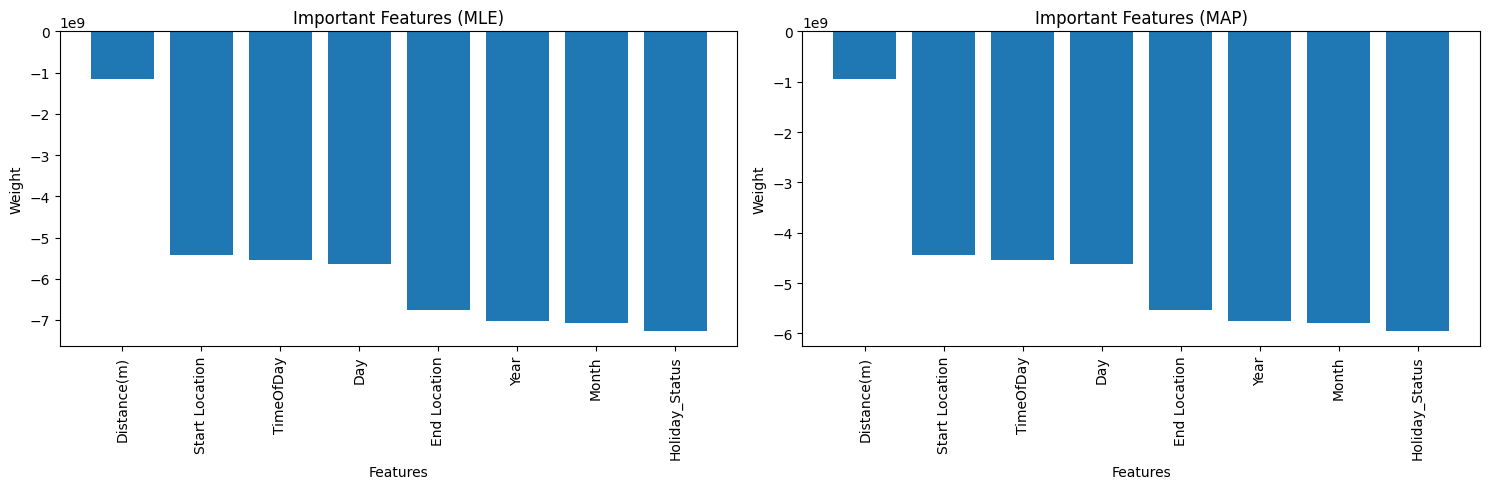

In [ ]:
# Initialise the input parameters (X) and output parameter (y)
X = df.drop('Duration(min)', axis=1)
feature_names = X.columns.tolist()
y = df['Duration(min)']

# Perform train-test split with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MLE (Maximum Likelihood Estimation)
weights_mle = poisson_regression_mle(X_train, y_train, learning_rate=0.001, max_iter=1000, tol=1e-6)

# MAP (Maximum A Posteriori Estimation) with L2 regularization
weights_map = poisson_regression_map(X_train, y_train, learning_rate=0.001, l2_penalty=0.1, max_iter=1000, tol=1e-6)

# Get the top 5 important features for MLE and MAP
important_features_mle = get_important_features(weights_mle, feature_names, top_n=8)
important_features_map = get_important_features(weights_map, feature_names, top_n=8)

# Extract feature names and weights for MLE
mle_feature_names = [feature for feature, weight in important_features_mle]
mle_weights = [weight for feature, weight in important_features_mle]

# Extract feature names and weights for MAP
map_feature_names = [feature for feature, weight in important_features_map]
map_weights = [weight for feature, weight in important_features_map]


# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


# Plot the bar plot for MLE
ax1.bar(mle_feature_names, mle_weights)
ax1.set_xlabel('Features')
ax1.set_ylabel('Weight')
ax1.set_title('Important Features (MLE)')
ax1.tick_params(axis='x', rotation=90)

# Plot the bar plot for MAP
ax2.bar(map_feature_names, map_weights)
ax2.set_xlabel('Features')
ax2.set_ylabel('Weight')
ax2.set_title('Important Features (MAP)')
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



---



## Model Training

The training and testing datasets (X_train1, X_test1) were refined by selecting only the features identified as significant by the Maximum A Posteriori (MAP) estimation process. Subsequently, the Poisson Regression model was trained using two different estimation techniques: Maximum Likelihood Estimation (MLE) and MAP with L2 regularization. Both models were trained with a learning rate of 0.001, a maximum of 1000 iterations, and a convergence tolerance of 1e-6. The MAP estimation additionally incorporated an L2 penalty of 0.1 to prevent overfitting.

In [ ]:
# Remove those columns from X which are not in map_feature_names
X_train1 = X_train[[col for col in X.columns if col in map_feature_names]]
X_test1 = X_test[[col for col in X.columns if col in map_feature_names]]

# MLE (Maximum Likelihood Estimation)
weights_mle = poisson_regression_mle(X_train1, y_train, learning_rate=0.001, max_iter=1000, tol=1e-6)
# MAP (Maximum A Posteriori Estimation) with L2 regularization
weights_map = poisson_regression_map(X_train1, y_train, learning_rate=0.001, l2_penalty=0.1, max_iter=1000, tol=1e-6)




---



## Model Evaluation

Predictions were generated for the validation dataset using the trained Poisson Regression models, employing both Maximum Likelihood Estimation (MLE) and Maximum A Posteriori (MAP) approaches. Subsequently, the predictive performance of both models was rigorously evaluated using established metrics: Mean Squared Error (MSE) and Mean Absolute Error (MAE). These metrics provide quantitative measures of the models' accuracy in predicting travel duration, enabling a comprehensive comparison of their effectiveness.

In [ ]:
# Predict on validation data (same as before)
poisson_predictions_mle = predict_poisson(X_test1, weights_mle)
poisson_predictions_map = predict_poisson(X_test1, weights_map)

# Evaluate both models using Mean Squared Error
poisson_mse_mle = mean_squared_error(y_test, poisson_predictions_mle)
poisson_mse_map = mean_squared_error(y_test, poisson_predictions_map)
# Evaluate both models using Mean Absolute Error
poisson_mae_mle = mean_absolute_error(y_test, poisson_predictions_mle)
poisson_mae_map = mean_absolute_error(y_test, poisson_predictions_map)

# Display results
data = {'Model': ['Poisson Regression (MLE)', 'Poisson Regression (MAP)'],
        'Mean Squared Error': [poisson_mse_mle, poisson_mse_map],
        'Mean Absolute Error': [poisson_mae_mle, poisson_mae_map]}
df = pd.DataFrame(data)
display(HTML(df.to_html(index=False)))

Model,Mean Squared Error,Mean Absolute Error
Poisson Regression (MLE),20518.893688,39.651163
Poisson Regression (MAP),20518.893688,39.651163




---



## Linear Regression

A **Linear Regression** model was instantiated and trained using the provided training data (X_train, y_train). Subsequently, the trained model was employed to generate predictions on the test data (X_test). The model's performance was then assessed using the Mean Squared Error (MSE) and Mean Absolute Error (MAE) metrics, providing quantitative measures of its predictive accuracy.

In [ ]:

# Create the linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate linear regression model using Mean Squared Error
linear_mse= mean_squared_error(y_test, y_pred)
# Evaluate linear regression model using Mean Absolute Error
linear_mae = mean_absolute_error(y_test, y_pred)

# Display results
data = {'Model': ['Linear Regression'],
        'Mean Squared Error': [linear_mse],
        'Mean Absolute Error': [linear_mae]}
df = pd.DataFrame(data)
display(HTML(df.to_html(index=False)))


Model,Mean Squared Error,Mean Absolute Error
Linear Regression,18344.855888,33.382807




---



## Model Comparison

The performance of the Poisson Regression (MLE), Poisson Regression (MAP), and Linear Regression models were evaluated and compared using Mean Squared Error (MSE) and Mean Absolute Error (MAE) metrics. The results were compiled into a Pandas DataFrame and presented in a tabular format for clear and concise comparison.

In [ ]:
# Compare results
data = {'Model': ['Poisson Regression (MLE)', 'Poisson Regression (MAP)','Linear Regression'],
        'Mean Squared Error': [poisson_mse_mle, poisson_mse_map,linear_mse],
        'Mean Absolute Error': [poisson_mae_mle, poisson_mae_map,linear_mae]}
df = pd.DataFrame(data)
display(HTML(df.to_html(index=False)))

Model,Mean Squared Error,Mean Absolute Error
Poisson Regression (MLE),20518.893688,39.651163
Poisson Regression (MAP),20518.893688,39.651163
Linear Regression,18344.855888,33.382807


**Conclusions:**

* **Comparison of Regression Models:**
In our analysis, we find that Linear Regression demonstrates superior performance compared to Poisson Regression for the given dataset.

* **Reason for Performance:**
The reason for this discrepancy lies in the nature of the data. The minute column, which represents the duration, contains a high frequency of data points, making it dense. This density provides enough information for Linear Regression to model the relationship effectively.

* **Impact of Data Granularity:**
However, if we were to alter the dataset by converting the duration from minutes to hours, the performance of Linear Regression would likely degrade. This is because representing duration in hours would reduce the number of unique data points, resulting in a sparser dataset.



---

